In [240]:
from kan import *
import torch
import matplotlib.pyplot as plt
from torch import autograd
from tqdm import tqdm
from pyscf import gto, scf
from collections import Counter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)

In [241]:
# DONE:  Input for nuclear positions - From FermiNet configs
#        Doesn't need to be automated for first go through, just get to calculating energy!
# BOND_LENGTHS = {
#     'BeH': 1.348263,
#     'CN': 1.134797,
#     'ClF': 1.659091,
#     'F2': 1.420604,
#     'H2': 0.737164,
#     'HCl': 1.2799799,
#     'Li2': 2.77306,
#     'LiH': 1.639999,
#     'N2': 1.129978,
#     'NH': 1.039428,
#     'CO': 1.150338,
#     'BH': 1.2324,  # Not in G3
#     'PN': 1.491,  # Not in G3
#     'AlH': 1.648,  # Not in G3
#     'AlN': 1.786,  # Not in G3
# }

# DONE:  Input of number of electrons - pyscf

# Build network - number of electrons, 1d functions, spin interation/feature

# Initialize functions considering nuclear and electronic info...
# Loss function for electronic structure, i.e. Schrodinger Equation
# VMC/MCMC for sampling functions and updating parameters through loss function evaluation/expectation value
# Update positions and functions

In [242]:
# Create molecule
mol = gto.M(
   atom = 'H 0 0 0;', # H 0 0 0.737164;',
   basis = 'sto-3g',
   spin = 1
)
# Total number of electrons
total_electrons = mol.nelectron

# Correct way to get atom symbols
nuclear_charges = mol.atom_charges()

def parse_atom_string(mol):
   # Split the atom string by semicolons
   atom_sections = mol.atom.split(';')
   
   # For each section, get the first alphabetic character(s)
   atoms = []
   for section in atom_sections:
       # Skip empty sections
       if section.strip():
           # Get first part of section (before numbers)
           atom_symbol = section.strip().split()[0]
           # Only add if it's an atomic symbol (letters only)
           if atom_symbol.isalpha():
               atoms.append(atom_symbol)
   
   return atoms

def create_unique_atom_dict(atoms, nuclear_charges):
    # Count occurrences of each atom
    atom_count = Counter()
    unique_atoms = []
    
    # Create unique keys for repeated atoms
    for atom in atoms:
        atom_count[atom] += 1
        if atom_count[atom] == 1:
            unique_atoms.append(atom)
        else:
            unique_atoms.append(f"{atom}_{atom_count[atom]}")
    
    # Create dictionary with unique keys
    return dict(zip(unique_atoms, nuclear_charges))

atoms = parse_atom_string(mol)
nuclear_charges = mol.atom_charges().tolist()

atom_charges = {f"{atom}_{i+1}" if atoms.count(atom) > 1 else atom: charge 
                for i, (atom, charge) in enumerate(zip(atoms, nuclear_charges))}

print(atom_charges) 

# Spin number info - fix spins by Hund's Rule, spin not present in Born-Oppenheimer Approx. 
# Learnable spins not needed/can be hard coded
n_alpha = mol.nelectron // 2  # Number of spin-up electrons
n_beta = mol.nelectron // 2   # Number of spin-down electrons

print(n_alpha, n_beta)

{'H': 1}
0 0


In [243]:
# Total number of electrons
total_electrons = mol.nelectron
total_electrons

NUM_ELECTRONS = total_electrons
INPUT_DIM = NUM_ELECTRONS
OUTPUT_DIM = NUM_ELECTRONS


# Create MultKAN model with specified widths
# Create the initial MultKAN model
model = MultKAN(width=[INPUT_DIM, [0, OUTPUT_DIM], 1], grid=5, k=5, seed=42, mult_arity=3)

# Create dataset
f = lambda x: torch.exp(-1*x[:,[0]]) / torch.sqrt(torch.tensor(np.pi))
dataset = create_dataset(f, n_var=INPUT_DIM, ranges=[0,1], normalize_input=True, train_num=10000)
print("Dataset shapes:", dataset['train_input'].shape, dataset['train_label'].shape)

checkpoint directory created: ./model
saving model version 0.0
Dataset shapes: torch.Size([10000, 1]) torch.Size([10000, 1])


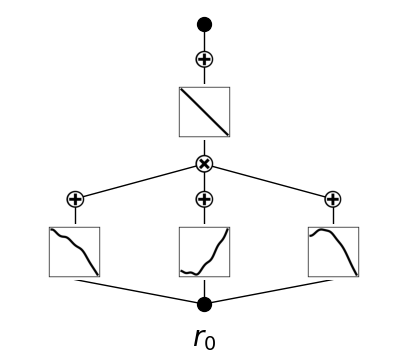

In [244]:
# def chain_str(in_out_dim: int, num_electrons: int) -> str:
#     connection_idxs = list(range(in_out_dim))

#     # Get first, second, and third third of input indices
#     radial_indices = connection_idxs[0::3]
#     theta_indices = connection_idxs[1::3]
#     phi_indices = connection_idxs[2::3]

#     # Get output indices with remainders 0, 1, and 2 when divided by 3
#     radial_electrons = [i for i in range(in_out_dim) if i % 3 == 0]
#     theta_electrons = [i for i in range(in_out_dim) if i % 3 == 1]
#     phi_electrons = [i for i in range(in_out_dim) if i % 3 == 2]

#     # Create three chains
#     first_chain = f'{radial_electrons}->{radial_indices}'
#     second_chain = f'{theta_electrons}->{theta_indices}'
#     third_chain = f'{phi_electrons}->{phi_indices}'

#     return [first_chain, second_chain, third_chain]

# chains = chain_str(INPUT_DIM, NUM_ELECTRONS)

# # Set up all connections
# for chain in chains:
#     model.module(0, chain)
       
# # # Create chain for final layer where all intermediate nodes connect to output
# final_indices = list(range(OUTPUT_DIM))
# final_chain = f'{final_indices}->[0]'
# model.module(1, final_chain)

# radial_vars = [r'$r_{'+str(i)+'}$' for i in range(NUM_ELECTRONS)]
# theta_vars = [r'$\theta_{'+str(i)+'}$' for i in range(NUM_ELECTRONS)]
# phi_vars = [r'$\phi_{'+str(i)+'}$' for i in range(NUM_ELECTRONS)]

# input_vars = radial_vars + theta_vars + phi_vars

model(dataset['train_input'])
model.plot(beta=10, in_vars=input_vars)

In [245]:
model.fit(dataset, steps=100, lamb=0.001);

| train_loss: 3.76e-03 | test_loss: 3.58e-03 | reg: 3.15e+00 | : 100%|█| 100/100 [00:29<00:00,  3.38

saving model version 0.1


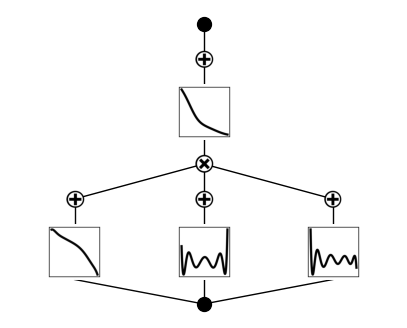

In [246]:
model.plot()

In [247]:
model = model.prune()

saving model version 0.2


In [248]:
model.fit(dataset, steps=20, lamb=0.001);

| train_loss: 3.58e-03 | test_loss: 3.42e-03 | reg: 3.15e+00 | : 100%|█| 20/20 [00:02<00:00,  7.59it

saving model version 0.3


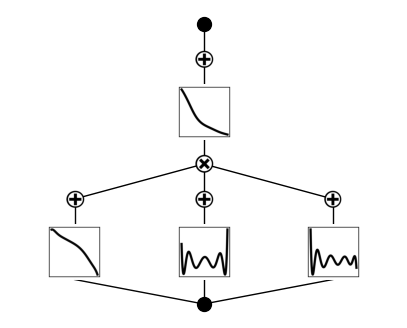

In [249]:
model.plot()

In [250]:
grids = np.array([3,10,20,50,100])

train_losses = []
test_losses = []
steps = 20

for i in range(grids.shape[0]):
    if i == 0:
        model = MultKAN(width=[INPUT_DIM, [0, OUTPUT_DIM], 1],  grid=grids[i], k=5, seed=42, mult_arity=3)

    if i != 0:
        model = model.refine(grids[i])
    results = model.fit(dataset, opt="LBFGS", steps=steps)
    train_losses += results['train_loss']
    test_losses += results['test_loss']

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.22e-03 | test_loss: 5.26e-03 | reg: 6.16e+00 | : 100%|█| 20/20 [00:06<00:00,  3.19it


saving model version 0.1
saving model version 0.2


| train_loss: 1.64e-03 | test_loss: 1.72e-03 | reg: 6.09e+00 | : 100%|█| 20/20 [00:06<00:00,  3.09it


saving model version 0.3
saving model version 0.4


| train_loss: 7.22e-04 | test_loss: 6.93e-04 | reg: 6.14e+00 | : 100%|█| 20/20 [00:09<00:00,  2.08it


saving model version 0.5
saving model version 0.6


| train_loss: 2.81e-04 | test_loss: 2.68e-04 | reg: 6.15e+00 | : 100%|█| 20/20 [00:19<00:00,  1.01it


saving model version 0.7
saving model version 0.8


| train_loss: 1.33e-04 | test_loss: 1.20e-04 | reg: 6.15e+00 | : 100%|█| 20/20 [00:41<00:00,  2.06s/

saving model version 0.9


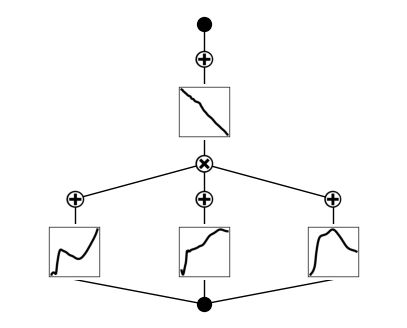

In [251]:
model.plot()

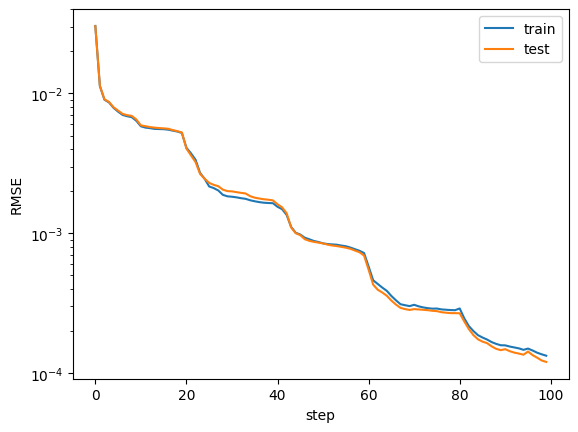

In [252]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

In [273]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
model.auto_symbolic(lib=lib)

skipping (0,0,0) since already symbolic
skipping (0,0,1) since already symbolic
skipping (0,0,2) since already symbolic
skipping (1,0,0) since already symbolic
saving model version 0.18


In [276]:
formula1 = model.symbolic_formula()
formula1

([-17.7821593345778*(0.129692047834396 + 7.54768180847168*exp(-4.83999916076664*(1 - 0.14545471737209*x_1)**2))*(0.0473921065888465*x_1 + 0.276206502077912)*(0.0959088053296*x_1 + 0.086662494025461) + 0.503519877071312],
 [x_1])

In [275]:
model.suggest_symbolic(0,0,0,a_range=(-40,40))

  function   fitting r2    r2 loss  complexity  complexity loss  total loss
0        0 -100000000.0  26.575425           0                0    5.315085
1        x -100000000.0  26.575425           1                1    6.115085
2      cos -100000000.0  26.575425           2                2    6.915085
3      sin -100000000.0  26.575425           2                2    6.915085
4      log -100000000.0  26.575425           2                2    6.915085


('0',
 (<function kan.utils.<lambda>(x)>,
  <function kan.utils.<lambda>(x)>,
  0,
  <function kan.utils.<lambda>(x, y_th)>),
 -100000000.0,
 0)

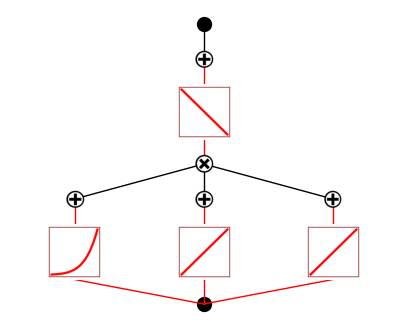

In [ ]:
model.plot()